<a href="https://colab.research.google.com/github/AshishGusain17/ML_Projs/blob/master/JanateHack_ML_in_agriculture/train_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

# 88858 rows × 10 columns

In [2]:
df_train = pd.read_csv('/content/train.csv')
df_train['train_flag'] = 1

print(df_train.shape)
df_test = pd.read_csv('/content/test.csv')
df_test['train_flag'] = 0
df_test['Crop_Damage'] = -1

print(df_test.shape)
df_data = pd.concat([df_train,df_test])
print(df_data.shape)
df_data.head()


(88858, 11)
(59310, 11)
(148168, 11)


,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag
0,F00000001,188,1,0,1,0,0.0,0,1,0,1
1,F00000003,209,1,0,1,0,0.0,0,2,1,1
2,F00000004,257,1,0,1,0,0.0,0,2,1,1
3,F00000005,257,1,1,1,0,0.0,0,2,1,1
4,F00000006,342,1,0,1,0,0.0,0,2,1,1


In [3]:
def removeF(x):
    s = x.strip('F')
    return s

df_data['ID_value'] = df_data['ID'].apply(removeF)
df_data['ID_value'] = df_data['ID_value'].astype('int')
df_data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_value
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
2,F00000004,257,1,0,1,0,0.0,0,2,1,1,4
3,F00000005,257,1,1,1,0,0.0,0,2,1,1,5
4,F00000006,342,1,0,1,0,0.0,0,2,1,1,6


In [4]:
df_data = df_data.sort_values(['ID_value'])
df_data = df_data.reset_index()
df_data.head()

,index,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_value
0,0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,0,F00000002,188,1,1,1,0,NaN,0,2,-1,0,2
2,1,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
3,2,F00000004,257,1,0,1,0,0.0,0,2,1,1,4
4,3,F00000005,257,1,1,1,0,0.0,0,2,1,1,5


In [5]:
df_data["Stage"] = 0
for i in range(df_data.shape[0]):
    if   df_data["Pesticide_Use_Category"][i] == 1:
        df_data["Stage"][i] = 1
    elif df_data["Pesticide_Use_Category"][i] == 3 and df_data["Crop_Type"][i] == 0:
        df_data["Stage"][i] = 2
    elif df_data["Pesticide_Use_Category"][i] == 3 and df_data["Crop_Type"][i] == 1:
        df_data["Stage"][i] = 3
    elif df_data["Pesticide_Use_Category"][i] == 2 and df_data["Soil_Type"][i] == 0 and df_data["Crop_Type"][i] == 0:
        df_data["Stage"][i] = 4
    elif df_data["Pesticide_Use_Category"][i] == 2 and df_data["Soil_Type"][i] == 1:
        df_data["Stage"][i] = 5
    elif df_data["Pesticide_Use_Category"][i] == 2 and df_data["Soil_Type"][i] == 0 and df_data["Crop_Type"][i] == 1:
        df_data["Stage"][i] = 6
    else:
        df_data["Stage"][i] =7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Sett

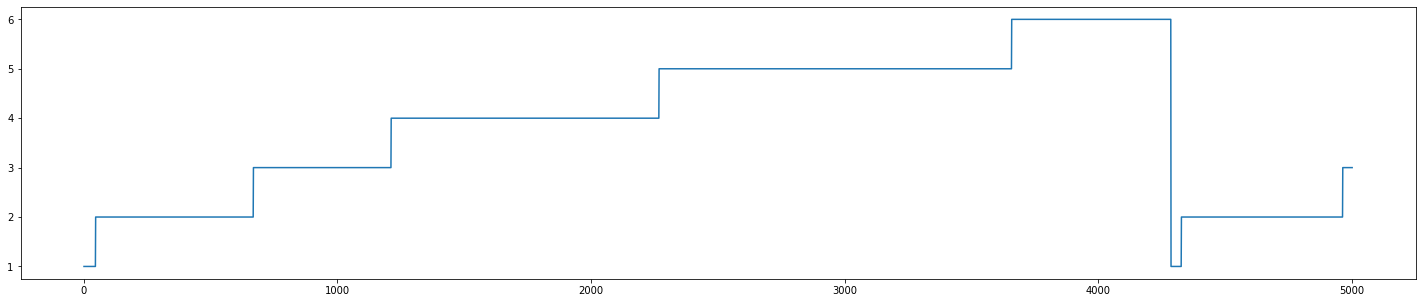

In [7]:
xrange = 5000
plt.figure(figsize=(25,5))
plt.plot(np.arange(1,xrange+1), df_data["Stage"][:xrange].values )


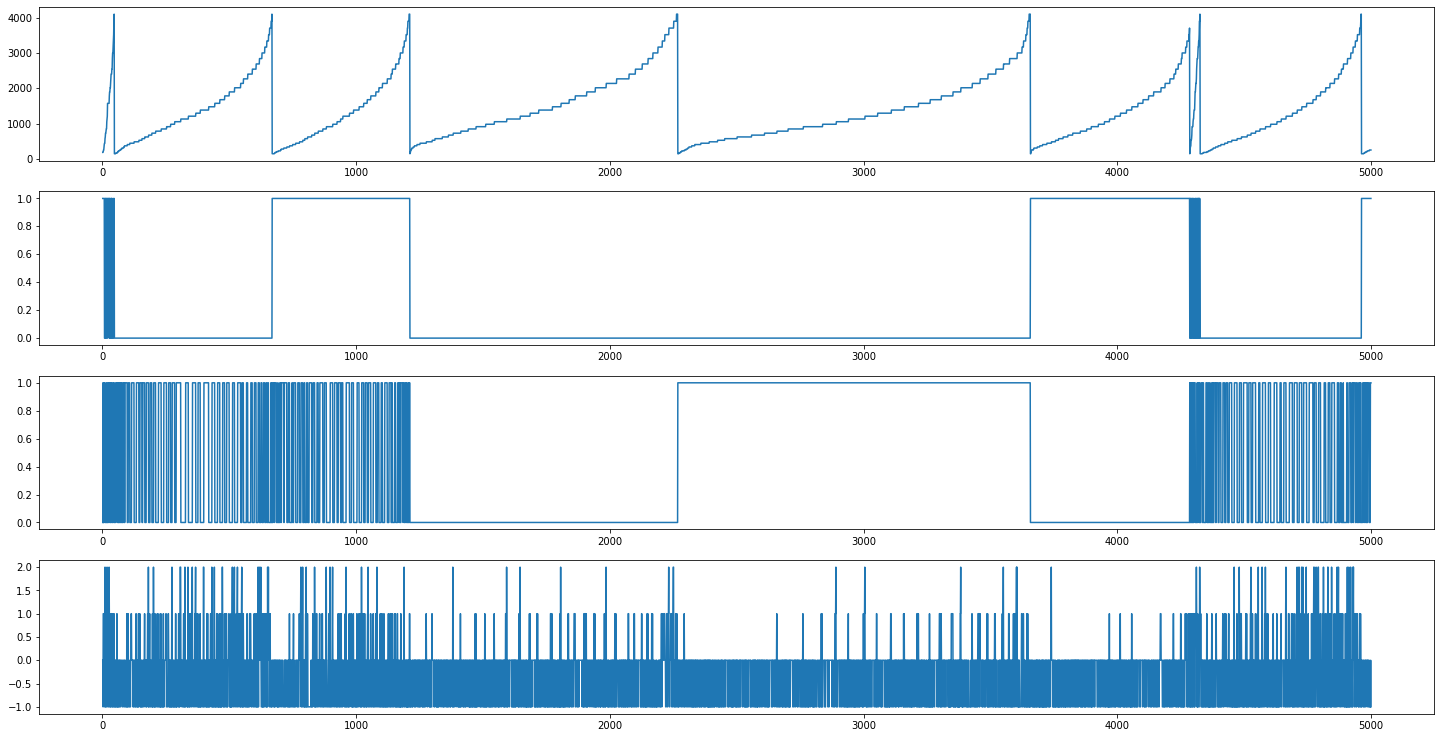

In [8]:
xrange = 5000
plt.figure(figsize=(25,13))
plt.subplot(4,1,1)
plt.plot(np.arange(1,xrange+1), df_data["Estimated_Insects_Count"][:xrange].values )

plt.subplot(4,1,2)
plt.plot(np.arange(1,xrange+1), df_data["Crop_Type"][:xrange].values )

plt.subplot(4,1,3)
plt.plot(np.arange(1,xrange+1), df_data["Soil_Type"][:xrange].values)

plt.subplot(4,1,4)
plt.plot(np.arange(1,xrange+1), df_data["Crop_Damage"][:xrange].values )


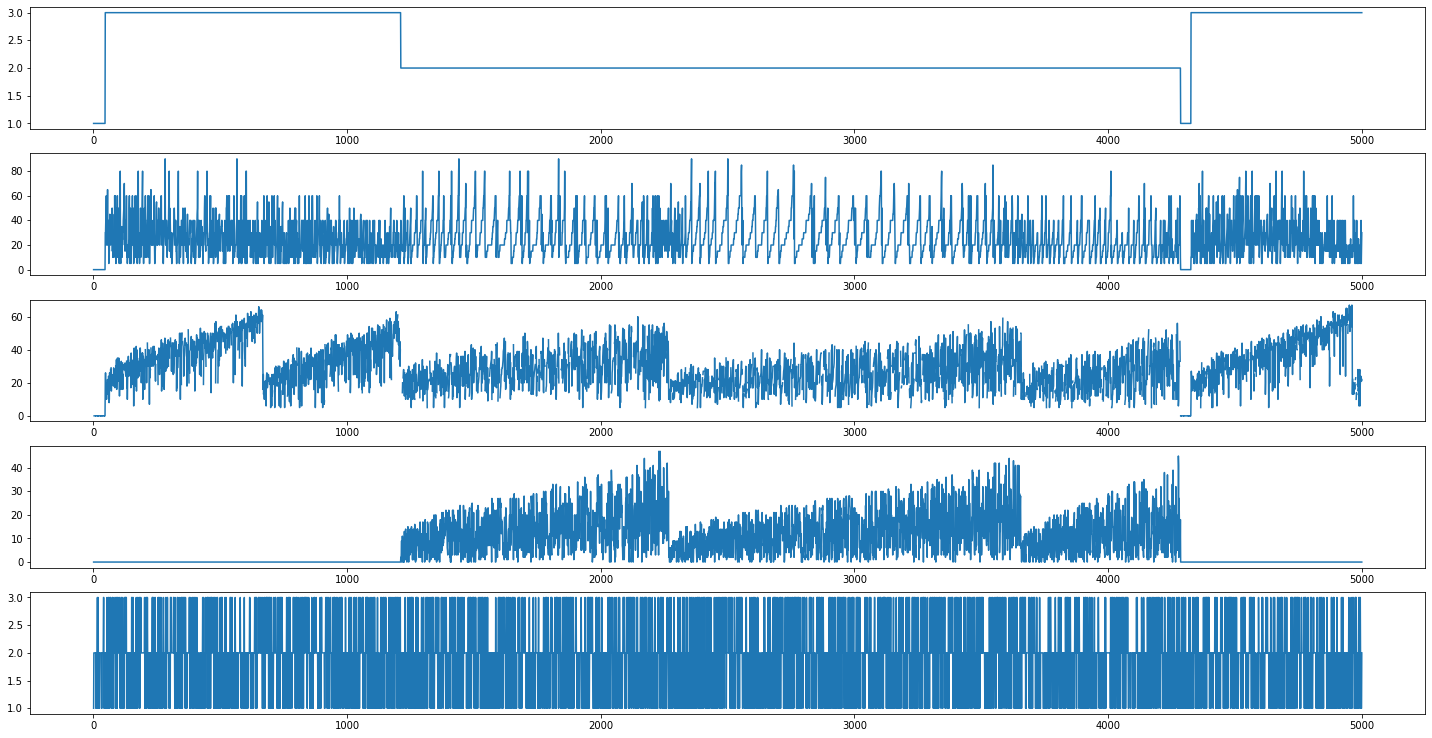

In [9]:
xrange = 5000
rows = 5
plt.figure(figsize=(25,13))
plt.subplot(rows,1,1)
plt.plot(np.arange(1,xrange+1), df_data["Pesticide_Use_Category"][:xrange].values)

plt.subplot(rows,1,2)
plt.plot(np.arange(1,xrange+1), df_data["Number_Doses_Week"][:xrange].values)


plt.subplot(rows,1,3)
plt.plot(np.arange(1,xrange+1), df_data["Number_Weeks_Used"][:xrange].values)

plt.subplot(rows,1,4)
plt.plot(np.arange(1,xrange+1), df_data["Number_Weeks_Quit"][:xrange].values)

plt.subplot(rows,1,5)
plt.plot(np.arange(1,xrange+1), df_data["Season"][:xrange].values)

In [11]:
df_data['Group_First'] = 0         # where group is starting, rank it 1
df_data['Group_Last'] = 0          # where group is ending rank it 1
df_data["Group"] = 0               # give numbering to every group
groupNo = 0                        # number of the group in increasing order

df_data["dose_change"] = 0         # Number_Doses_Week going from increase to decrease everytime



for i in range(1,df_data.shape[0]):
    if (abs(df_data['Estimated_Insects_Count'][i] - df_data['Estimated_Insects_Count'][i-1]) > 1):
        groupNo = groupNo + 1
        df_data['Group'][i] = groupNo
        df_data['Group_First'][i] = 1
        df_data['Group_Last'][i-1] = 1

    else:
        if (df_data['Number_Doses_Week'][i] < df_data['Number_Doses_Week'][i-1])  :
            df_data["dose_change"] = 1
            groupNo = groupNo + 1
            df_data['Group'][i] = groupNo
            df_data['Group_First'][i] = 1
            df_data['Group_Last'][i-1] = 1
            
        else:
            if (df_data['Soil_Type'][i] == df_data['Soil_Type'][i-1]):
                df_data['Group'][i] = groupNo 
            else:
                groupNo = groupNo + 1
                df_data['Group'][i] = groupNo
                df_data['Group_First'][i] = 1
                df_data['Group_Last'][i-1] = 1




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to b

In [13]:
# Group_Count   ===>>       total samples in one group 

df_data["Group_Count"] = 0
allCounts = df_data["Group"].value_counts()
for i in range(df_data.shape[0]):
    df_data["Group_Count"][i] = allCounts[df_data["Group"][i]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
pd.set_option('display.max_rows', 5000)
arr = ["Estimated_Insects_Count" , "Crop_Type" , "Soil_Type" ,"Pesticide_Use_Category", "Number_Doses_Week" , "Crop_Damage" , "Group" ,  "Group_First" , "Group_Last", "Group_Count" , "dose_change"]
df_data[:5000][arr]

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Crop_Damage,Group,Group_First,Group_Last,Group_Count,dose_change
0,188,1,0,1,0,0,0,0,1,1,1
1,188,1,1,1,0,-1,1,1,1,1,1
2,209,1,0,1,0,1,2,1,1,1,1
3,257,1,0,1,0,1,3,1,1,1,1
4,257,1,1,1,0,1,4,1,1,1,1
5,342,1,0,1,0,1,5,1,1,1,1
6,410,1,1,1,0,-1,6,1,1,1,1
7,448,0,1,1,0,1,7,1,0,2,1
8,448,0,1,1,0,1,7,0,1,2,1
9,577,1,0,1,0,2,8,1,1,1,1


In [24]:
def naive_random_search(X , Y):
    # classifier = XGBClassifier(n_jobs = -1)
    # param_grid = {
    #     "n_estimators" : np.arange(500,800,100),
    #     "max_depth" : np.arange(4,7)
    # }

    classifier = LGBMClassifier()
    param_grid = {"max_depth":[4,6,8,10,-1],
          "learning_rate":[0.001,0.005,0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0,0.25,0.5,1,2],
          "reg_lambda":[0,0.25,0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,1001,100))}

    model = RandomizedSearchCV(estimator = classifier,
                        param_distributions = param_grid,
                        cv = 5,
                        n_iter = 10,
                        verbose=1000
                        )
    model.fit(X,Y)

    return model



def pred_naive_random_search(model):
    # submit = pd.read_csv("/content/test.csv")
    # submit['Number_Weeks_Used'] = submit['Number_Weeks_Used'].replace(np.nan, 0)
    # submit['Number_Weeks_Quit'] = submit['Number_Weeks_Quit'].replace(np.nan, 0)
    # submit['Season'] = submit['Season'].replace(np.nan, 0)



    arr = ["ID", "Estimated_Insects_Count", "Crop_Type", "Soil_Type", "Pesticide_Use_Category", "Number_Doses_Week","Number_Weeks_Used", "Number_Weeks_Quit",
           "Stage",
           "Group" , "Group_First" , "Group_Last" , "Group_Count" ,
           "dose_change"]


    test = df_data[df_data["train_flag"] == 0][arr]
    col1 = test["ID"]
    arr.remove("ID")
    X = test[arr]
    print(X.shape)



    # arr_to_stan = np.array(submit["Estimated_Insects_Count"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Estimated_Insects_Count"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Doses_Week"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Doses_Week"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Weeks_Used"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Weeks_Used"] = scaler.fit_transform(arr_to_stan) 

    # arr_to_stan = np.array(submit["Number_Weeks_Quit"]).reshape((-1,1))
    # scaler = MinMaxScaler(feature_range=(0, 1)) 
    # X["Number_Weeks_Quit"] = scaler.fit_transform(arr_to_stan) 

    # np.set_printoptions(precision=3)

    col2 = model.predict(X)

    dict = {'ID': col1, 'Crop_Damage': col2} 
    df_fin = pd.DataFrame(dict) 
    df_fin.to_csv('pred_naive_feat.csv', index=False)



In [25]:
df_data['Number_Weeks_Used'] = df_data['Number_Weeks_Used'].replace(np.nan, 0)
df_data['Number_Weeks_Quit'] = df_data['Number_Weeks_Quit'].replace(np.nan, 0)
# df_data = df_data.sample(frac=1)

arr = ["Estimated_Insects_Count", "Crop_Type", "Soil_Type", "Pesticide_Use_Category", "Number_Doses_Week","Number_Weeks_Used", "Number_Weeks_Quit","Crop_Damage",
        "Stage",
        "Group" , "Group_First" , "Group_Last" , "Group_Count" ,
        "dose_change"]
# arr = [ "Estimated_Insects_Count", "Crop_Type", "Soil_Type", "Pesticide_Use_Category", "Number_Doses_Week","Number_Weeks_Used", "Number_Weeks_Quit", "Crop_Damage"]

test = df_data[df_data["train_flag"] == 1][arr]
Y = test["Crop_Damage"]
arr.remove("Crop_Damage")
X = test[arr]
print(X.shape , Y.shape)
model = naive_random_search(X , Y)
X.info()


(88858, 13) (88858,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7, score=0.926, total=  10.4s
[CV] subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7, score=0.925, total=  10.4s
[CV] subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7, score=0.928, total=  10.4s
[CV] subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.2s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7, score=0.927, total=  10.5s
[CV] subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.7s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=1, reg_alpha=0.25, num_leaves=15, n_estimators=950, min_data_in_leaf=3, max_depth=-1, learning_rate=0.01, colsample_bytree=0.7, score=0.871, total=  10.4s
[CV] subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.1s remaining:    0.0s


[CV]  subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7, score=0.835, total=   6.4s
[CV] subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   58.5s remaining:    0.0s


[CV]  subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7, score=0.835, total=   6.4s
[CV] subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7, score=0.835, total=   6.4s
[CV] subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV]  subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7, score=0.835, total=   6.3s
[CV] subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  subsample=0.9, reg_lambda=1, reg_alpha=1, num_leaves=127, n_estimators=450, min_data_in_leaf=25, max_depth=6, learning_rate=0.001, colsample_bytree=0.7, score=0.835, total=   6.5s
[CV] subsample=0.8, reg_lambda=0.25, reg_alpha=1, num_leaves=15, n_estimators=450, min_data_in_leaf=7, max_depth=10, learning_rate=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, reg_lambda=0.25, reg_alpha=1, num_leaves=15, n_estimators=450, min_data_in_leaf=7, max_depth=10, learning_rate=0.01, colsample_bytree=0.7, score=0.925, total=   5.1s
[CV] subsample=0.8, reg_lambda=0.25, reg_alpha=1, num_leaves=15, n_estimators=450, min_data_in_leaf=7, max_depth=10, learning_rate=0.01, colsample_bytree=0.7 
[CV]  subsample=0.8, reg_lambda=0.25, reg_alpha=1, num_leaves=15, n_estimators=450, min_data_in_leaf=7, max_depth=10, learning_rate=0.01, colsample_bytree=0.7, score=0.926, total=   5.1s
[CV] subsample=0.8, reg_lambda=0.25, reg_alpha=1, num_leaves=15, n_estimators=450, min_data_in_leaf=7, max_depth=10, learn

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.0min finished


<class 'pandas.core.frame.DataFrame'>
Int64Index: 88858 entries, 0 to 148167
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Estimated_Insects_Count  88858 non-null  int64  
 1   Crop_Type                88858 non-null  int64  
 2   Soil_Type                88858 non-null  int64  
 3   Pesticide_Use_Category   88858 non-null  int64  
 4   Number_Doses_Week        88858 non-null  int64  
 5   Number_Weeks_Used        88858 non-null  float64
 6   Number_Weeks_Quit        88858 non-null  int64  
 7   Stage                    88858 non-null  int64  
 8   Group                    88858 non-null  int64  
 9   Group_First              88858 non-null  int64  
 10  Group_Last               88858 non-null  int64  
 11  Group_Count              88858 non-null  int64  
 12  dose_change              88858 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 9.5 MB


In [26]:
print(model.best_score_)
print(model.best_estimator_.get_params())
print(model.score(X,Y))
pred_naive_random_search(model)

0.9259830390518694
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 450, 'n_jobs': -1, 'num_leaves': 15, 'objective': None, 'random_state': None, 'reg_alpha': 1, 'reg_lambda': 0.25, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'min_data_in_leaf': 7}
0.927749893087848
(59310, 13)


In [ ]:
import scipy
arr = df.columns.values
arr = arr.tolist()
arr.remove('ID')

for i in arr:
    a,b = scipy.stats.pearsonr(df["Crop_Damage"],df[i])
    print(i,a,b)

# corelation-coefficient        p-value       
# corelation coefficient close to 1 or -1 and p-value < 0.001 is considered strong corelation


Estimated_Insects_Count 0.20379572434428975 0.0
Crop_Type -0.01709710916643973 1.353200772452846e-06
Soil_Type -0.024569104068500176 3.812549517857125e-12
Pesticide_Use_Category 0.1765520668378686 0.0
Number_Doses_Week -0.03096670779075563 2.0795220014947948e-18
Number_Weeks_Used 0.2321920383032649 0.0
Number_Weeks_Quit -0.13311604791752846 1.99275288465e-312
Season 0.0006338132894572154 0.8578532835741154
Crop_Damage 1.0 0.0


(79858, 10)


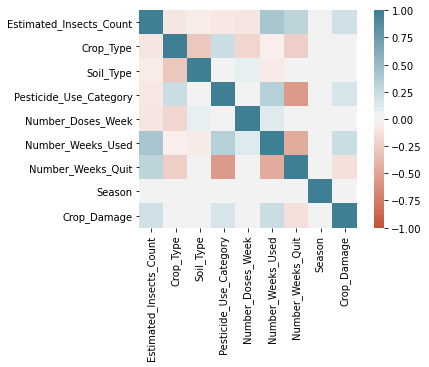

In [ ]:
import seaborn as sns
print(df.shape)
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

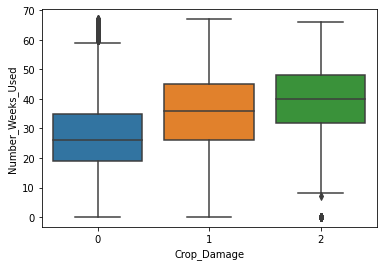

In [ ]:
import seaborn as sns
sns.boxplot(y="Number_Weeks_Used",x="Crop_Damage",data=df)

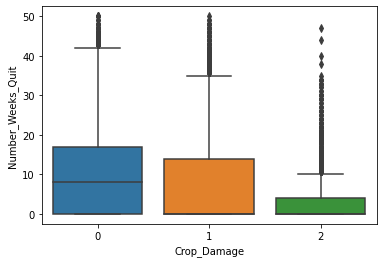

In [ ]:
sns.boxplot(y="Number_Weeks_Quit",x="Crop_Damage",data=df)

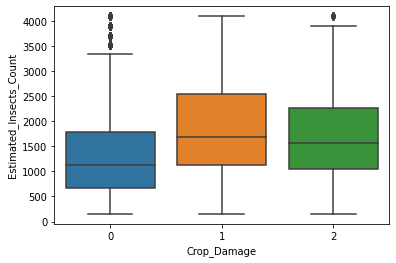

In [ ]:
sns.boxplot(y="Estimated_Insects_Count",x="Crop_Damage",data=df)